In [1]:
pip install mlxtend 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

In [6]:
titanic = pd.read_csv('Titanic Train.csv')
nominal_cols = ['Embarked','Pclass','Age', 'Survived', 'Sex']
cat_cols = ['Embarked','Pclass','Age', 'Survived', 'Title']
titanic['Title'] = titanic.Name.str.extract('\, ([A-Z][^ ]*\.)',expand=False)
titanic['Title'].fillna('Title_UK', inplace=True)
titanic['Embarked'].fillna('Unknown',inplace=True)
titanic['Age'].fillna(0, inplace=True)
# Replacing Binary with String
rep = {0: "Dead", 1: "Survived"}
titanic.replace({'Survived' : rep}, inplace=True)

In [8]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,Dead,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.
1,2,Survived,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.
2,3,Survived,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.
3,4,Survived,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.
4,5,Dead,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.


In [9]:
def binning(col, cut_points, labels=None):
  minval = col.min()
  maxval = col.max()
  break_points = [minval] + cut_points + [maxval]
  if not labels:
    labels = range(len(cut_points)+1)
  colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
  return colBin

cut_points = [1, 20, 50 ]
labels = ["Unknown", "Young", "Adult", "Old"]
titanic['Age'] = binning(titanic['Age'], cut_points, labels)
in_titanic = titanic[nominal_cols]
cat_titanic = titanic[cat_cols]

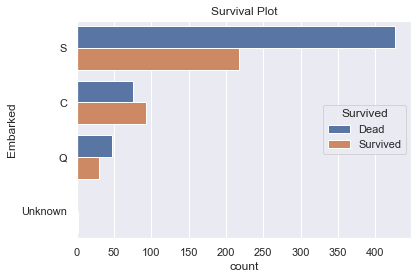

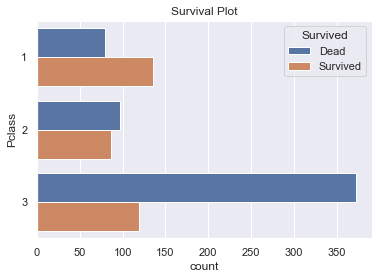

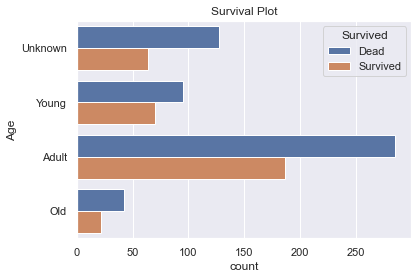

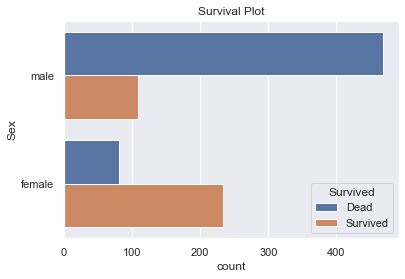

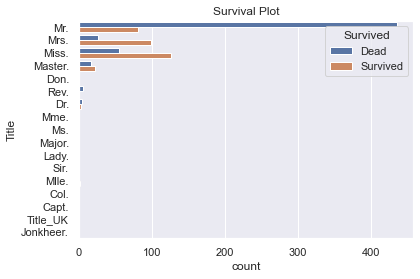

In [14]:
for x in ['Embarked', 'Pclass','Age', 'Sex', 'Title']:
    sns.set(style="darkgrid")
    ax = sns.countplot(y=x, hue="Survived", data=titanic)
    plt.ylabel(x)
    plt.title('Survival Plot')
    plt.show()

In [15]:
dataset = []
for i in range(0, in_titanic.shape[0]-1):
    dataset.append([str(in_titanic.values[i,j]) for j in range(0, in_titanic.shape[1])])
# dataset = in_titanic.to_xarray()

oht = TransactionEncoder()
oht_ary = oht.fit(dataset).transform(dataset)
df = pd.DataFrame(oht_ary, columns=oht.columns_)
df.head()

,1,2,3,Adult,C,Dead,Old,Q,S,Survived,Unknown,Young,female,male
0,False,False,True,True,False,True,False,False,True,False,False,False,False,True
1,True,False,False,True,True,False,False,False,False,True,False,False,True,False
2,False,False,True,True,False,False,False,False,True,True,False,False,True,False
3,True,False,False,True,False,False,False,False,True,True,False,False,True,False
4,False,False,True,True,False,True,False,False,True,False,False,False,False,True


In [16]:
oht.columns_

['1',
 '2',
 '3',
 'Adult',
 'C',
 'Dead',
 'Old',
 'Q',
 'S',
 'Survived',
 'Unknown',
 'Young',
 'female',
 'male']

In [17]:
output = apriori(df, min_support=0.2, use_colnames=oht.columns_)
output.head()

,support,itemsets
0,0.242697,(1)
1,0.206742,(2)
2,0.550562,(3)
3,0.528090,(Adult)
4,0.615730,(Dead)


In [ ]:
config = [
    ('antecedent support', 0.7),
    ('support', 0.5),
    ('confidence', 0.8),
    ('conviction', 3)
]

for metric_type, th in config:
    rules = association_rules(output, metric=metric_type, min_threshold=th)
    if rules.empty:
        print ('Empty Data Frame For Metric Type : ',metric_type,' on Threshold : ',th)
        continue
    print (rules.columns.values)
    print ('-------------------------------------')
    print ('Configuration : ', metric_type, ' : ', th)
    print ('-------------------------------------')
    print (rules)

    support=rules.as_matrix(columns=['support'])
    confidence=rules.as_matrix(columns=['confidence'])

    plt.scatter(support, confidence, edgecolors='red')
    plt.xlabel('support')
    plt.ylabel('confidence')
    plt.title(metric_type+' : '+str(th))
    plt.show()

In [19]:
rules[rules['confidence']==rules['confidence'].min()]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
6,(S),"(Adult, 3)",0.723596,0.248315,0.213483,0.295031,1.188134,0.033804,1.066267


In [20]:
rules[rules['confidence']==rules['confidence'].max()]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,(S),(male),0.723596,0.647191,0.495506,0.684783,1.058084,0.027201,1.119256


In [21]:
rules = association_rules (output, metric='support', min_threshold=0.1)
rules[rules['confidence'] == rules['confidence'].min()]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
33,(S),"(Adult, 3)",0.723596,0.248315,0.213483,0.295031,1.188134,0.033804,1.066267


In [22]:
rules[rules['confidence'] == rules['confidence'].max()]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
76,"(3, S, male)",(Dead),0.297753,0.61573,0.259551,0.871698,1.415714,0.076215,2.995043
